# Process Model simulation
In this example, we present a simple process model and simulate its execution to obtain performance metrics.
## Initialization
As usual, we start the notebook by initializing the Modelverse connection.
Additionally, we will be using matplotlib to draw a figure at the end, so include it now already

In [1]:
import sys
sys.path.append("../wrappers/")
from modelverse import *
init()
login(None, None)

%matplotlib inline
import matplotlib.pyplot as plt

## Load libraries
Load all the necessary formalisms and activities first.
They might already exist in the Modelverse, but it doesn't matter that much now: just overwrite.
Also loads the DEVS library for process modelling building blocks.

In [2]:
model_add("~/formalisms/DEVS/DEVS_MM", "formalisms/SimpleClassDiagrams", open("../models/ClassicDEVS/metamodels/DEVS.mvc", 'r').read())
model_add("~/formalisms/PM/PM_Extended_MM", "formalisms/SimpleClassDiagrams", open("../models/FTGPM/metamodels/control_patterns.mvc", 'r').read())
model_add("~/formalisms/Experiment/Experiment_MM", "formalisms/SimpleClassDiagrams", open("../models/PythonPDEVS_Experiment/metamodels/experiment.mvc", 'r').read())
model_add("~/models/DEVS/PM_library", "~/formalisms/DEVS/DEVS_MM", open("../models/ClassicDEVS/models/process_patterns_library.mvc", 'r').read())
model_add("~/formalisms/String", "formalisms/SimpleClassDiagrams", open("../models/String/metamodels/String.mvc", 'r').read())

def traceability_pm_devs(model):
    instantiate(model, "Association", ("PM/ProcessNode", "DEVS/DEVSInstance"), ID="Trace")

transformation_add_MT({"PM": "~/formalisms/PM/PM_Extended_MM"}, {"DEVS": "~/formalisms/DEVS/DEVS_MM"}, "~/formalisms/PM/to_DEVS", open("../models/FTGPM/transformations/patterns_to_DEVS.mvc", 'r').read(), traceability_pm_devs)
transformation_add_AL({"model1": "~/formalisms/DEVS/DEVS_MM", "model2": "~/formalisms/DEVS/DEVS_MM"}, {"result": "~/formalisms/DEVS/DEVS_MM"}, "~/formalisms/DEVS/merge", open("../models/ClassicDEVS/transformations/merge.alc", 'r').read())
transformation_add_AL({"DEVS": "~/formalisms/DEVS/DEVS_MM", "Experiment": "~/formalisms/Experiment/Experiment_MM"}, {"result": "~/formalisms/String"}, "~/formalisms/DEVS/simulate", open("../models/ClassicDEVS/transformations/simulate.alc", 'r').read())

model_add("~/models/PM/to_DEVS", "formalisms/ProcessModel", open("../models/FTGPM/PM_patterns_simulation_relative.mvc", 'r').read())

## Specify Input
Next we specify the input models and the experiment that we wish to perform.
The input Process Model is the one that will be simulated, and can be tuned in a variety of ways, such as through the use of different parameters.
The experiment can be further tweaked to alter the range of available resources or to change the number of samples.

In [3]:
model_add("~/models/PM/example_PM", "~/formalisms/PM/PM_Extended_MM", """
    Initial init {
        name = "initial"
    }
    Activity req {
        name = "define_requirements"
        distribution = "lambda iteration: max(0.0, random.gauss(10.0 * (1-math.exp(-(iteration+1) / 0.7)), (10.0 * (1-math.exp(-(iteration+1) / 0.7)))*0.15625))"
    }
    SimpleMerge merge {
        name = "merge_0"
    }
    Activity model {
        name = "model_system"
        distribution = "lambda iteration: max(0.0, random.gauss(100.0 * (1-math.exp(-(iteration+1) / 0.7)), (100.0 * (1-math.exp(-(iteration+1) / 0.7)))*0.15625))"
    }
    ParallelSplit split {
        name = "split_0"
    }
    MultiInstance simulate {
        name = "simulate"
        nr_instances = 10
        distribution = "lambda iteration: max(0.0, random.gauss(20.0 * (1-math.exp(-(iteration+1) / 0.7)), (20.0 * (1-math.exp(-(iteration+1) / 0.7)))*0.15625))"
    }
    Activity check {
        name = "check"
        distribution = "lambda iteration: max(0.0, random.gauss(30.0 * (1-math.exp(-(iteration+1) / 0.7)), (30.0 * (1-math.exp(-(iteration+1) / 0.7)))*0.15625))"
    }
    Synchronization sync {
        name = "sync_0"
    }
    Activity evaluate {
        name = "evaluate"
        distribution = "lambda iteration: max(0.0, random.gauss(0.1 * (1-math.exp(-(iteration+1) / 0.7)), (0.1 * (1-math.exp(-(iteration+1) / 0.7)))*0.15625))"
    }
    ExclusiveChoice choice {
        name = "xor_0"
        distribution = "lambda iteration: random.random() > {0: 0.99, 1: 0.9, 2: 0.8, 3: 0.5, 4: 0.2, 5: 0.1, 6: 0.02}.get(iteration, 0.0)"
    }
    Finish finish {
        name = "finish"
    }

    Next (init, req) {}
    Next (req, merge) {}
    Next (merge, model) {}
    Next (model, split) {}
    Next (split, simulate) {}
    Next (split, check) {}
    Next (simulate, sync) {}
    Next (check, sync) {}
    Next (sync, evaluate) {}
    Next (evaluate, choice) {}
    DecisionTrue (choice, finish) {}
    DecisionFalse (choice, merge) {}
    """)

In [4]:
model_add("~/models/Experiment/example_experiment", "~/formalisms/Experiment/Experiment_MM", """
    Experiment {
        code = \"\"\"
    import random
    import math

    from pypdevs.simulator import Simulator

    def simulate(nresources, seed):
        random.seed(seed)
        model = Root('root', [nresources])
        sim = Simulator(model)
        sim.setClassicDEVS()
        sim.simulate()
        return model.submodels['finish'].state

    def main():
        results = ''
        for i in range(1, 14):
            results = results + str(i)
            for v in range(2, 10):
                results = results + ' ' + str(simulate(i, v))
            results = results + '\\n'
        return results
        \"\"\"
    }
    """)

## Enact process
Finally we enact the process, thereby generating the *~/results* model.

In [5]:
process_execute("~/models/PM/to_DEVS", {"PM": "~/models/PM/example_PM", "DEVS library": "~/models/DEVS/PM_library", "Experiment": "~/models/Experiment/example_experiment", "result": "~/result"}, {})

Finally plot the simulation results, by reading out the value of the string model.
Using this information, we split it up and then forward it to matplotlib for plotting as a boxplot.

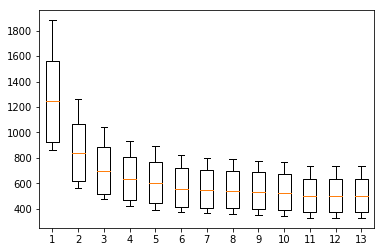

In [6]:
results = read_attrs("~/result", all_instances("~/result", "String").pop())["value"]
data = results.strip().split("\n")
data = [i.split() for i in data]
data = [[float(j) for j in i[1:]] for i in data]
plt.boxplot(data);